In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

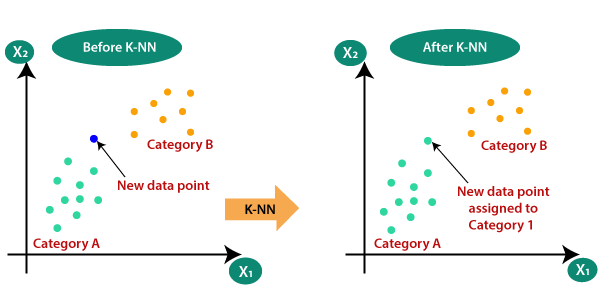

#KNN CLASSIFIERS
* Non-parametric
* Commonly used distance metric is the Euclidean distance

$d(x,y) = \sqrt(\sum(x_i - y_i)^2)$

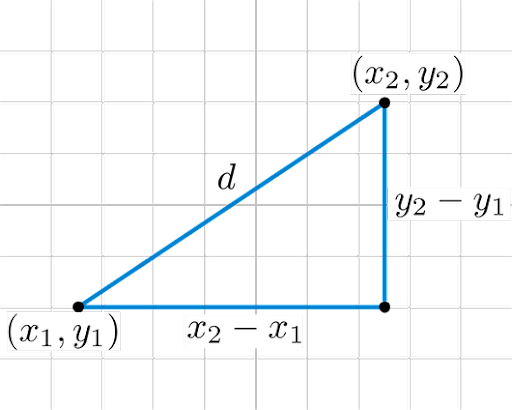

# Data Loading and General Overview

In [ ]:
df = pd.read_csv("../input/kopacsv/KOPA.csv")
df.head(2)

In [ ]:
df.info()

In [ ]:
df['LoanStatus360'].value_counts().plot(kind='barh')
plt.title("Distribution of Target Variable")

# Data Preprocessing/Cleaning. 
1. Label encoding of Categorical features
2. Handling date-time columns
3. Feature interaction(subjective)
4. Scaling(subjective)

In [ ]:
df.head(2)

# Handling categorical data

In [ ]:
cat_cols = ['Product', 'CustomerGender', 'Location', 'Region']
def frequency_encoding(df, col):
    fe = df.groupby(col).size()/len(df)
    df[col+"_encoded"] = df[col].map(fe)
    return df
new_df = frequency_encoding(df, 'Product')
new_df = frequency_encoding(new_df, 'CustomerGender')
new_df = frequency_encoding(new_df, 'Location')
new_df = frequency_encoding(new_df, 'Region')
new_df = new_df.drop(columns=cat_cols, axis=1)
new_df.head(2)

# Handling datetime

In [ ]:
new_df['StartDate'] = pd.to_datetime(new_df['StartDate'])
new_df.head(2)

In [ ]:
new_df['Year'] = new_df['StartDate'].dt.year
new_df['month'] = new_df['StartDate'].dt.month
new_df['date'] = new_df['StartDate'].dt.day
new_df.columns

In [ ]:
new_df = new_df.drop(columns=['StartDate'], axis=1)

# Feature interaction

In [ ]:
#feature interaction
new_df['loan_amount_paid'] = new_df['TotalDays'] * new_df['DailyRate']
new_df['AmountPaidSum'] = new_df['AmountPaid30']+new_df['AmountPaid60'] + new_df['AmountPaid360']


# Modelling

In [ ]:
X = new_df.drop(columns=['LoanStatus360'], axis=1)
y = new_df['LoanStatus360']

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
#using default hyperparameters
model1 = KNeighborsClassifier()
result = cross_val_score(model1, X, y, n_jobs=-1, scoring='accuracy')
final_result = np.mean(result)
final_result

# Hyper-parameter tuning: Bayesian Optimization
* Bayesian  optimization is ideal in instances where we have a large number of hyperparameters
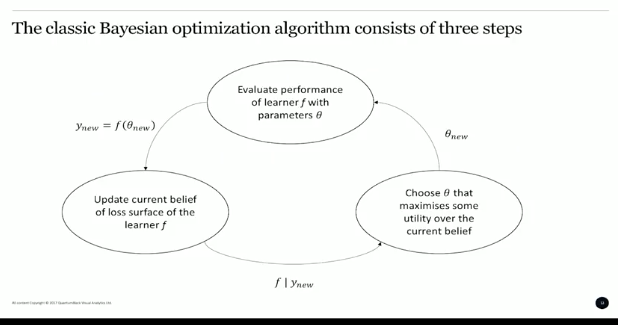

* Here, $\theta$ are our parameters
* For a classification problem, the performance metric may be the accuracy or auc score, for regression it may be the rmse, mse, mae etc
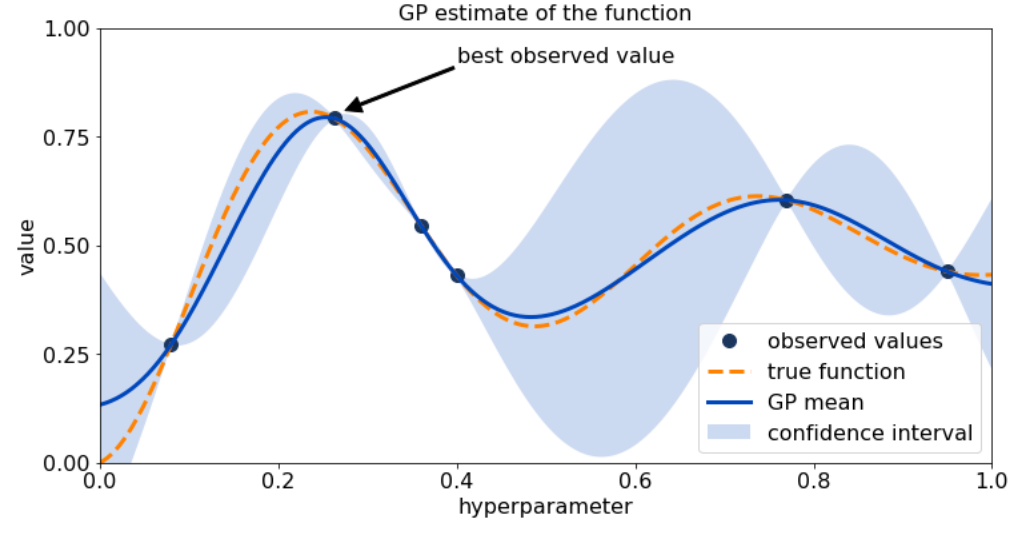
* GP is a gaussian distribution applied over a distribution of functions rather than a distribution of random variables. (in this case function is the model developed). 
* GP is defined by its mean function and covariance function(analoguous to mean and variance in random variables). 
* Blue dots ==> where the function has been evaluated and we are certain of the results. 
* We can see that the variance is low and we have low uncertainity. 
* Places with high uncertainties are places where we haven't evaluated the function
* How do we know which regions to explore next to minimize our variance, i.e improve our performance? Using acquisition functions. 
* Commonly used acquisition functions include:
    1. Expected improvement functions
    2. Probability of improvement. 
    3. Lower confidence bound function
* Focusing on expected improvement:
    $EI(\theta) = E[max_\theta [ 0, (yi(\theta)-y_{i-1}(\theta))]]$ 
* Exploration vs Exploitation: strategies used in improving the performance of the model. Need to know which one to work with. 

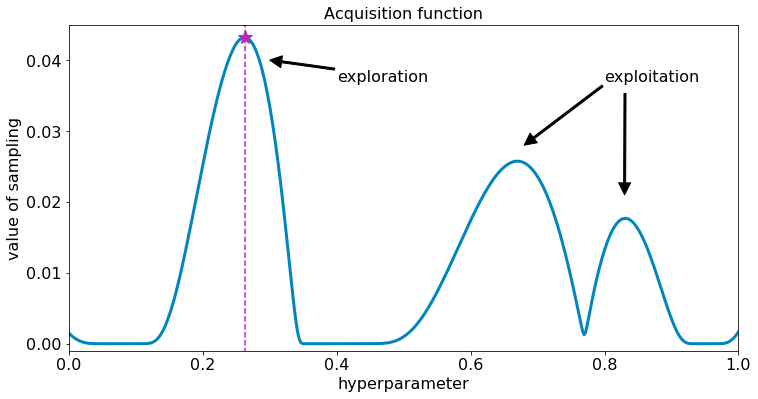

* Result of Bayesian Optimization in SVC
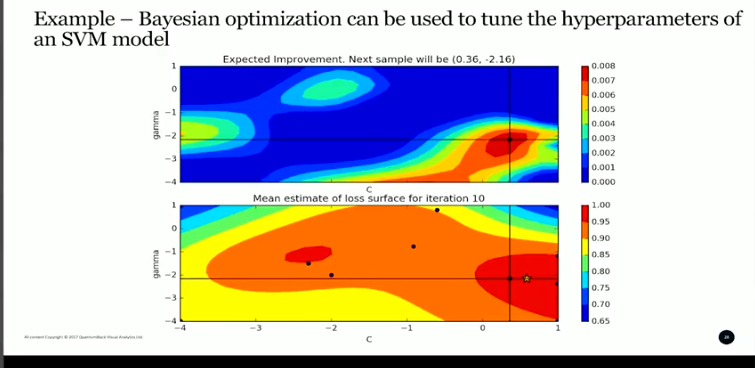

In [ ]:
%%time
##Objective of this step is to obtain optimum parameters that will yield the best result.
## It is not guaranteed that the performance will change drastically
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = np.mean(result)
	return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))